<img src="https://devra.ai/analyst/notebook/1865/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;">  <div style="font-size:150%; color:#FEE100"><b>Google Daily Stock Prices Analysis</b></div>  <div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div></div>

# Table of Contents

- [Introduction](#Introduction)
- [Imports and Configurations](#Imports-and-Configurations)
- [Data Loading](#Data-Loading)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Feature Engineering](#Feature-Engineering)
- [Prediction Modeling](#Prediction-Modeling)
- [Model Evaluation](#Model-Evaluation)
- [Conclusion](#Conclusion)

# Introduction

This notebook dives into the intriguing world of Google's daily stock prices from 2004 to today. The data presents not only the beauty of financial time series but also the challenges of predicting the seemingly unpredictable. If you find these insights useful or you chuckled at our occasional dry humor, please consider upvoting this notebook.

In [1]:
# Imports and Configurations
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Ensuring backend compatibility for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Switching backend if only plt is imported
%matplotlib inline  

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

# Set seaborn style for better visuals
sns.set(style='whitegrid')

# Print a simple statement to verify execution
print('Imports and configurations are successfully set up.')

Imports and configurations are successfully set up.


# Data Loading

We are now going to load the dataset from the specified CSV file. Note that the date column, originally a string, will be converted to a datetime type for easier handling and visualization.

In [2]:
# Load the dataset
file_path = '/kaggle/input/google-daily-stock-prices-2004-today/googl_daily_prices.csv'
df = pd.read_csv(file_path, encoding='ascii')

# Converting the 'date' column into datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Display basic information about the dataset
print('Dataset loaded. Shape:', df.shape)
print(df.dtypes)

Dataset loaded. Shape: (5210, 6)
date         datetime64[ns]
1. open             float64
2. high             float64
3. low              float64
4. close            float64
5. volume           float64
dtype: object


# Data Cleaning and Preprocessing

In this section, we'll address any potential issues with the data. This includes handling missing values and ensuring that our data types are set correctly. The date conversion step above is crucial to allow for time-based insights later on.

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print('Missing values in each column:')
print(missing_values)

# Depending on the results, you might want to drop or impute missing values.
# Here we choose to drop rows with missing dates because a valid date is essential for time series analysis.
df = df.dropna(subset=['date'])

# Rename columns for easier access: remove leading numbers and spaces
df.columns = [col.split('. ')[-1].strip() if '. ' in col else col for col in df.columns]
print('\nColumns after renaming:', df.columns.tolist())

Missing values in each column:
date         0
1. open      0
2. high      0
3. low       0
4. close     0
5. volume    0
dtype: int64

Columns after renaming: ['date', 'open', 'high', 'low', 'close', 'volume']


# Exploratory Data Analysis

Let's explore the dataset through a variety of visualizations. We start with a correlation heatmap on the numeric columns to uncover relationships between the stock price metrics. Subsequently, other plots (pair plot, histogram, box plot, etc.) provide further insights into the distributions and relationships in the data.

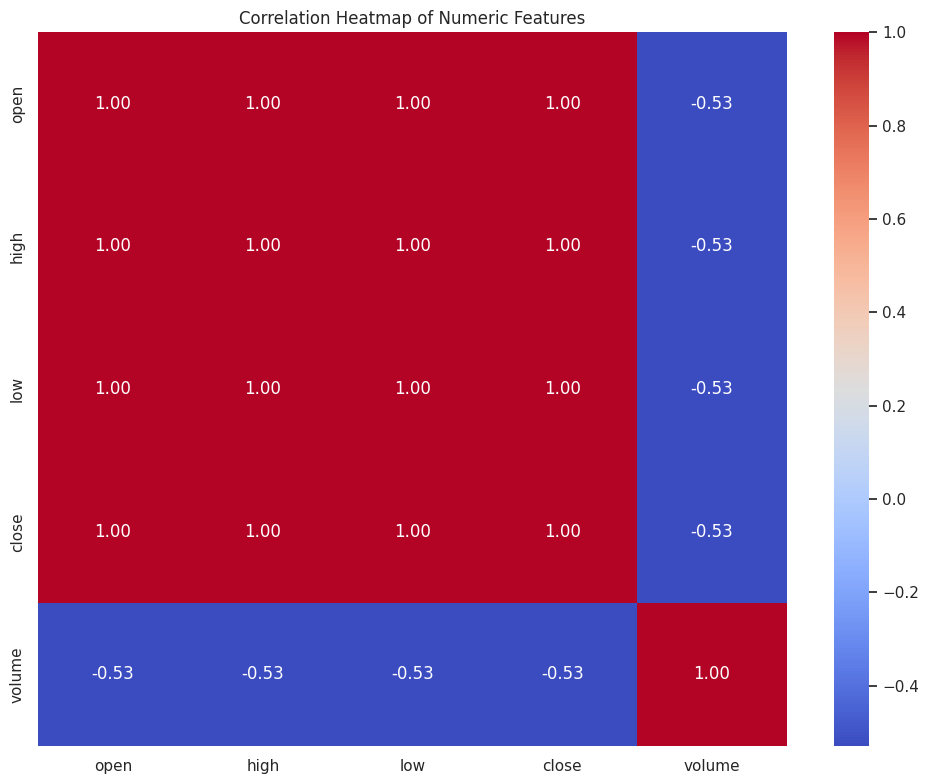

In [4]:
# Selecting numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=[np.number])

# Generate a correlation heatmap if we have four or more numeric columns
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()
else:
    print('Not enough numeric columns for a meaningful correlation heatmap.')

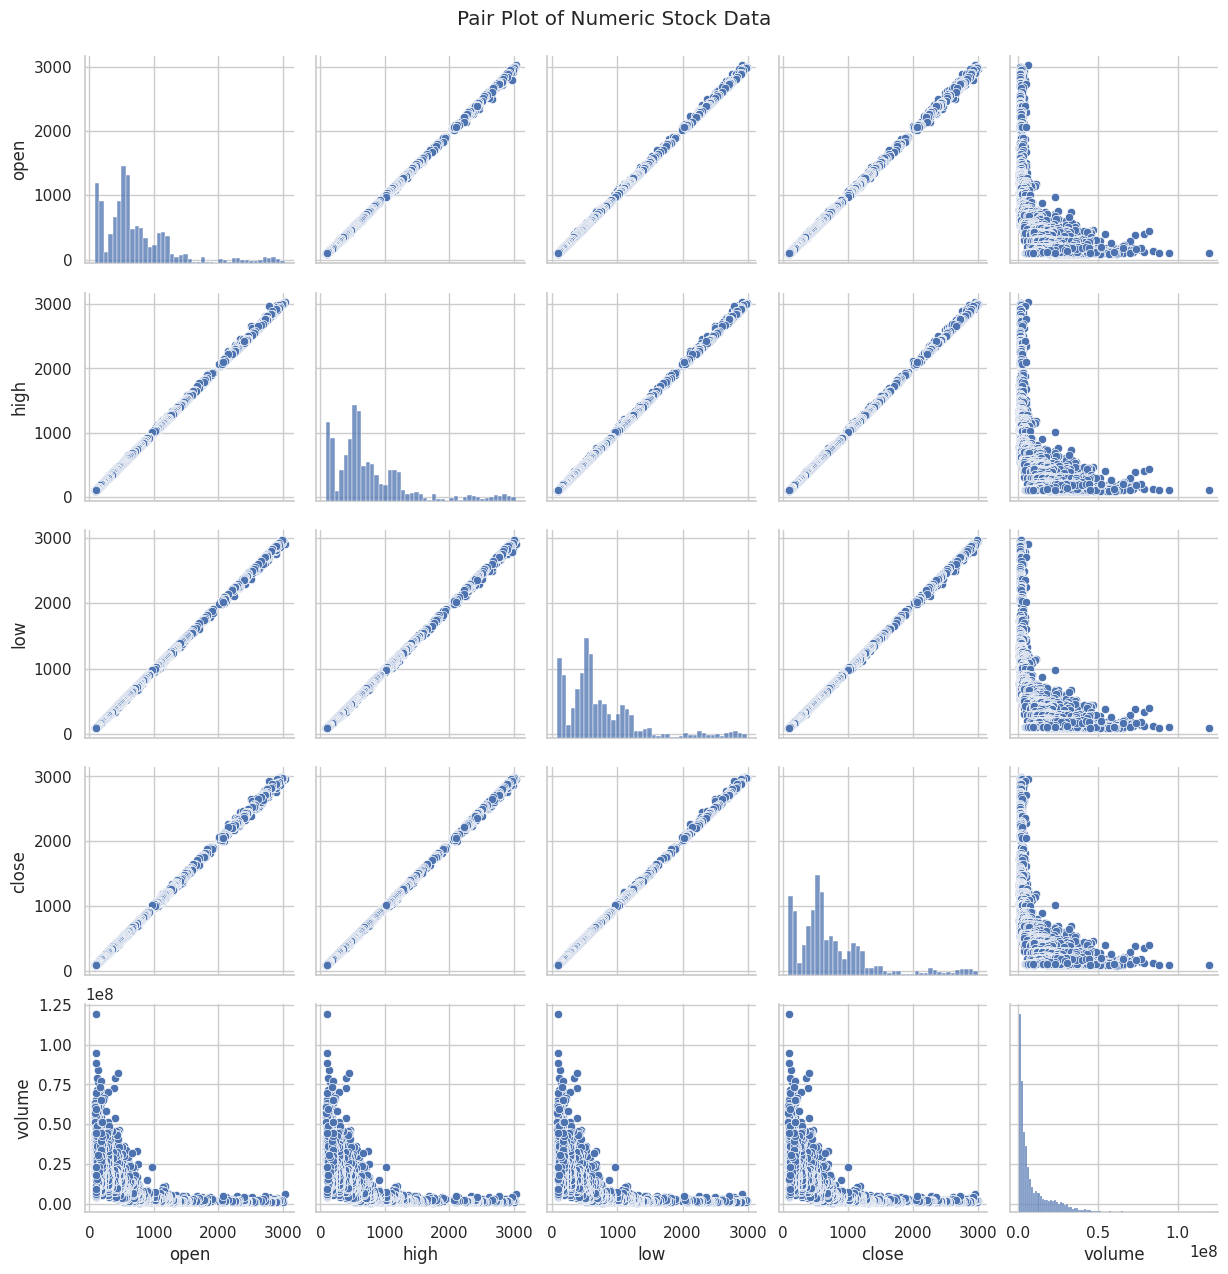

In [5]:
# Pair plot for a quick glance at potential relationships
sns.pairplot(df, vars=numeric_df.columns.tolist(), diag_kind='hist')
plt.suptitle('Pair Plot of Numeric Stock Data', y=1.02)
plt.savefig('pairplot.png')
plt.show()

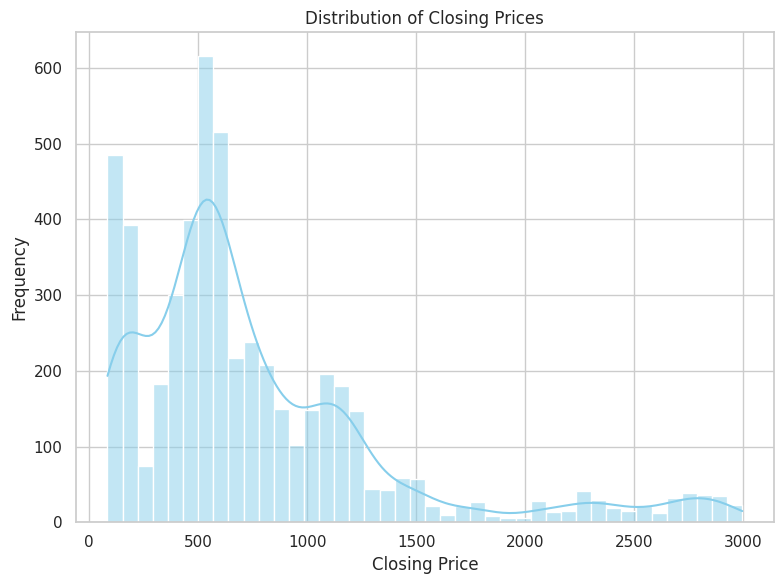

In [6]:
# Histogram of the 'close' prices to see its distribution
plt.figure(figsize=(8, 6))
sns.histplot(df['close'], kde=True, color='skyblue')
plt.title('Distribution of Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('close_price_histogram.png')
plt.show()

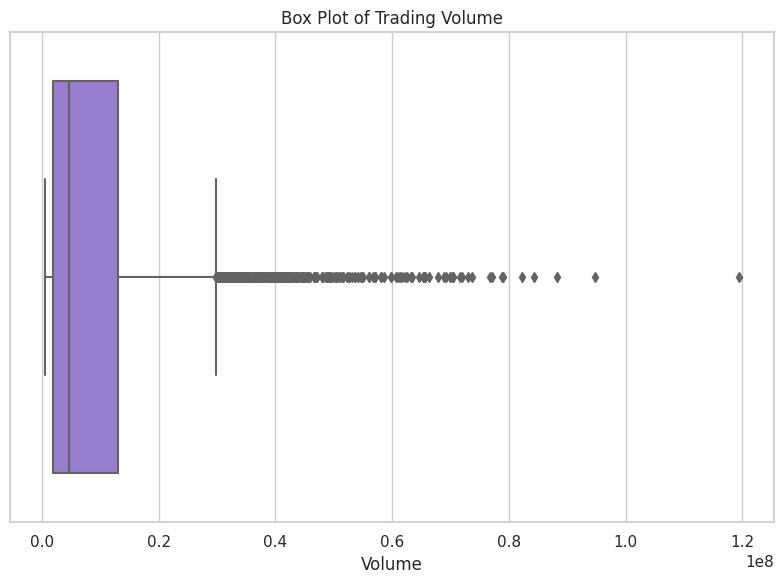

In [7]:
# Box plot to check for outliers in 'volume'
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['volume'], color='mediumpurple')
plt.title('Box Plot of Trading Volume')
plt.xlabel('Volume')
plt.tight_layout()
plt.savefig('volume_boxplot.png')
plt.show()

# Feature Engineering

We add some additional features to facilitate further analysis and prediction.
Here, we derive the year and month from the date column to allow for time-based group summaries and trends.

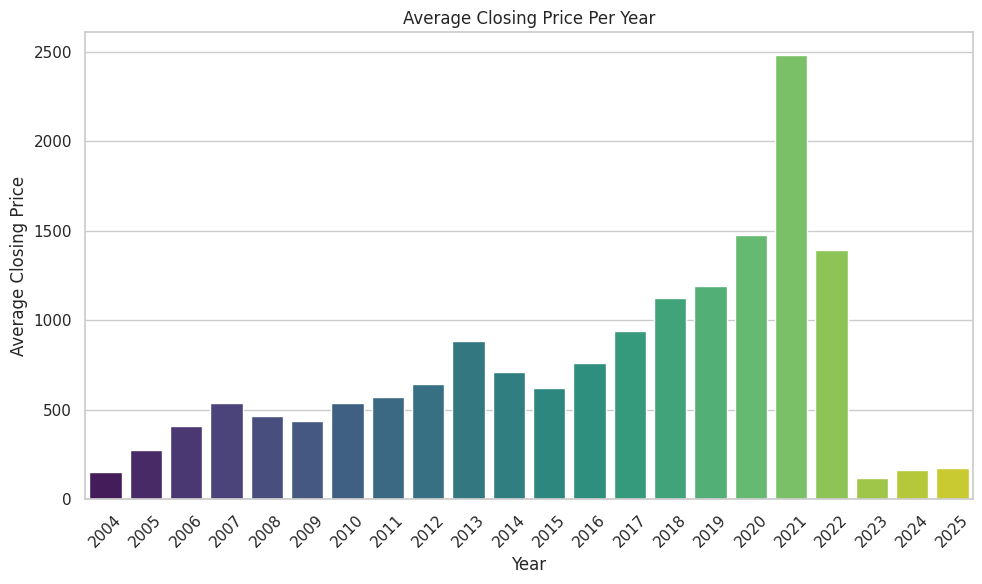

In [8]:
# Create additional date-based features
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month

# A grouped bar plot to see average closing price per year (for illustration purposes)
annual_avg = df.groupby('Year')['close'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='close', data=annual_avg, palette='viridis')
plt.title('Average Closing Price Per Year')
plt.xlabel('Year')
plt.ylabel('Average Closing Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('annual_avg_close_barplot.png')
plt.show()

# Prediction Modeling

In this section, we take a stab at predicting the closing price based on the other available features. While the stock market remains notoriously capricious, we extract some signal using a Random Forest Regressor. The target variable is the 'close' price and predictors include 'open', 'high', 'low', and 'volume'.

In [9]:
# Prepare the data for prediction
features = ['open', 'high', 'low', 'volume']
target = 'close'

# Drop rows with missing values in feature columns
df_model = df.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

# Split the data into training and testing sets (80:20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print('Random Forest model has been trained.')

Random Forest model has been trained.


# Model Evaluation

After training the model, we evaluate its performance on the test data using the R² score, a common metric for regression tasks. Additionally, we compute the permutation importance to understand which features most influence our predictions.

R^2 score for the Random Forest model: 0.9998


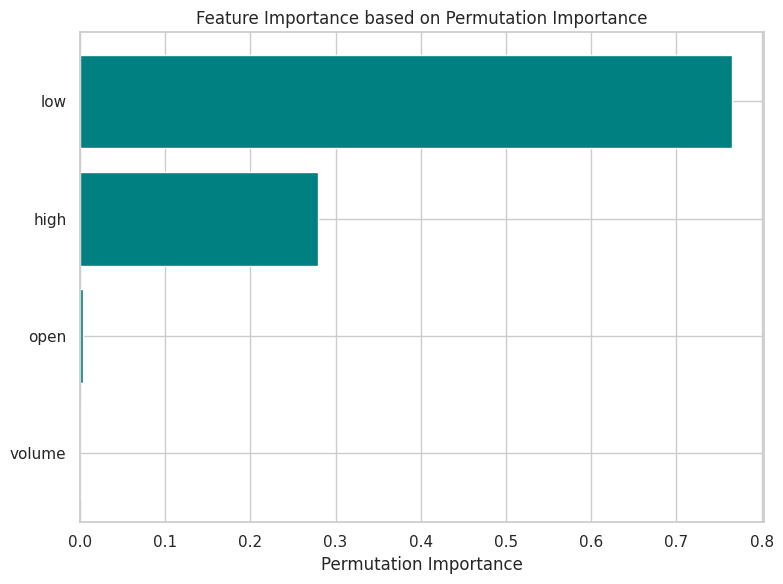

In [10]:
# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model using R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 score for the Random Forest model: {r2:.4f}')

# Permutation importance to see feature influence
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42)

# Prepare and plot permutation importances
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(np.array(features)[sorted_idx], perm_importance.importances_mean[sorted_idx], color='teal')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance based on Permutation Importance')
plt.tight_layout()
plt.savefig('permutation_importance.png')
plt.show()

# Conclusion

This notebook demonstrated a comprehensive approach to analyzing Google's daily stock prices. We started with data cleaning and exploratory analysis and then moved on to create a predictive model for the closing price. While the stock market remains inherently unpredictable, our model provides a baseline for regression-based approaches. Future work could include:

- Incorporating additional time series modeling techniques such as ARIMA or LSTM networks.
- Expanding the feature set with technical indicators (e.g., moving averages or RSI).
- Performing a more detailed time-based split to better simulate live trading scenarios.

If you found the notebook useful, please consider upvoting it. Happy analyzing!